# **Time series forecasting**

This tutorial is an introduction to **time series forecasting** using TensorFlow.

It builds a few different styles of models including **Recurrent Neural Networks**.

This is covered in two main parts, with subsections:
- Forecast for a **single time step**:
- Forecast **multiple steps**:
  - **Single-shot**: Make the predictions all at once.
  - **Autoregressive**: Make one prediction at a time and feed the output back to the model.

## Setup

In [ ]:
import os
import datetime

import random
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
seed = 42

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# **The weather dataset**

This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as `air temperature, atmospheric pressure, and humidity`. These were collected `every 10 minutes`, beginning in 2003. For efficiency, you will use only the data collected between `2009 and 2016` (this section of the dataset was prepared by François Chollet for his book <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>).

In [ ]:
# download and unzip dataset
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

print(zip_path)
csv_path = os.path.join(zip_path, "jena_climate_2009_2016.csv")
print(csv_path)

In [ ]:
# TODO: load csv data into a Pandas DataFrame
df = ...
df

As a first step when dealing with a dataset, we need to check:

- Are there any null values?
- Are there any missing data?
- Do we have the correct granularity?
- Are there any out-of-scale values?

In [ ]:
# TODO: check for null values
...

In [ ]:
# check for missing values
df["Date Time"] = df["Date Time"].astype("datetime64[ms]")

date_rng = pd.date_range(start='2009-01-01 00:10:00', end='2017-01-01 00:00:00', freq='10min')
df_ideal = pd.DataFrame({'value': range(len(date_rng))}, index=date_rng)

df_ideal.index.difference(df["Date Time"].values)

In [ ]:
df[df['Date Time'] == "08.10.2009 10:00:00"] # remember we have to use English data format

This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [ ]:
# TODO: resample dataframe to hourly timestamps
# HINT: keep attention to missing values !!
...

In [ ]:
# TODO: extract the timestamp column
date_time = ...
date_time

Let's take a glance at the data. Here are the first few rows:

In [ ]:
df.head()

Here is the evolution of a few features over time:

In [ ]:
# plot some data
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, title="All Dataset")

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True, title="First 480 values")

plt.tight_layout()
plt.show()

Next, look at the statistics of the dataset:

In [ ]:
# TODO: plot some metrics about the dataframe (min, max, mean, std, ...)
...

One thing that should stand out is the `min` value of the wind velocity (`wv (m/s)`) and the maximum value (`max. wv (m/s)`) columns. This `-9999` is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (`>=0`).

We have several ways to deal with this problem:
- remove compromised rows
- replace with some computed values (like mean)
- replace with a fixed value
- try to guess the wrong values

For ease of time we replace them with zeros.

In [ ]:
# TODO: replace erroenus values with 0
# NOTE: df.method(..., inplace=True) is deprecated !!
...

df.describe().transpose()

#### **Time**

The `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
timestamp_s

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable `signals` by using `sine` and `cosine` transforms to clear "*Time of day*" and "*Time of year*" signals:

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

plt.show()

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important.

### **Split the data**

You'll use a `(70%, 20%, 10%)` split for the `training`, `validation`, and `test` sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

# TODO: split the data (70, 20, 10)
n = len(df)
train_df = ...
val_df =  ...
test_df = ...

num_features = df.shape[1]

In [ ]:
print(n)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(column_indices)

### **Normalize the data**

It is important to scale features before training a neural network.

`Standardization` is a common way of doing this scaling: `subtract the mean` and `divide by the standard deviation` of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [ ]:
# TODO: standardize datasets
# NOTE: avoid data leakage !!!
train_mean = ...
train_std = ...

train_df = ...
val_df = ...
test_df = ...

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

plt.show()

## **Data windowing**

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:

- The `width` (**number of time steps**) of the input and label windows.
- The `time offset` between them.
- **Which features are used as inputs, labels, or both.**

This tutorial builds a variety of models (DNN, CNN and RNN models), and uses them for both:

- *Single-output* predictions. FORSE VA TOLTO
- *Single-time-step* and *multi-time-step* predictions.

This section focuses on implementing the data windowing so that it can be reused for all of those models.





Depending on the task and type of model you may want to generate a variety of data windows. Here are some examples:

1. For example, to make a single prediction 24 hours into the future, given 24 hours of history, you might define a window like this:

  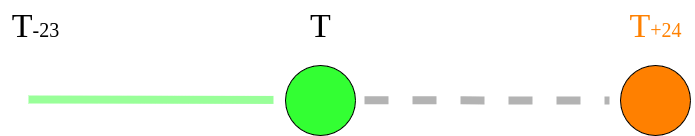

2. A model that makes a prediction one hour into the future, given six hours of history, would need a window like this:

 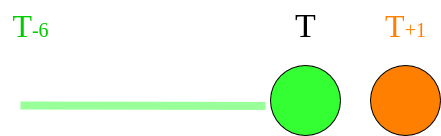

The previous ways to handle windows can be coded into a more practical representationa as follow:

1. An input width of 24 items with an offset (into the future) of 24 items and label width equals to 1 (meaning i want just the last one element)

  ![One prediction 24 hours into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_24h.png?raw=1)

2. An input width of 6 items with an offset (into the future) of 1 element and 1 for the label width:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

  Using this format we can represent all the possible window types we need !

The rest of this section defines a `WindowGenerator` class. This class can:

1. Handle the indexes and offsets as shown in the diagrams above.
1. Split windows of features into `(features, labels)` pairs.
2. Plot the content of the resulting windows.
3. Efficiently generate batches of these windows from the training, evaluation, and test data, using `tf.data.Dataset`s.

### 1. **Indexes and offsets**

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, offset,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}

    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = ...
    self.label_width = ...
    self.offset = ...

    self.total_window_size = ...

    self.input_slice = ...
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = ...
    self.labels_slice = ...
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, offset=24,
                     label_columns=['T (degC)'])
w1

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, offset=1,
                     label_columns=['T (degC)'])
w2

### 2. **Split**

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

The example `w2` you define earlier will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)

This diagram doesn't show the `features` axis of the data, but this `split_window` function also handles the `label_columns` so it can be used for both the single output and multi-output examples.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes manually
  # This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

### 3. **Plot**

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

In [ ]:
w2.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

### 4. **Create `tf.data.Dataset`s**

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.test)) # should be test !!!
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

### **Compile and Fit function**

This tutorial trains many models, so package the training procedure into a function:



In [ ]:
MAX_EPOCHS = 20
val_performance = {}
performance = {}

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  # TODO: set
  #       - MSE loss
  #       - Adam optimizer
  #       - Add MAE to metrics
  model.compile(...)

  # TODO: train the model using training and validation sets
  history = model.fit(..., callbacks=[early_stopping])
  return history

## **Recurrent neural network**

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

In this tutorial, you will use an RNN layer called Long Short-Term Memory (`tf.keras.layers.LSTM`).

An important constructor argument for all Keras RNN layers, such as `tf.keras.layers.LSTM`, is the `return_sequences` argument. This setting can configure the layer in one of two ways:

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction:

![An LSTM warming up and making a single prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_1_window.png?raw=1)

2. If `True`, the layer returns an output for each input. This is useful for:
  * Stacking RNN layers.
  * Training a model on multiple time steps simultaneously.

![An LSTM making a prediction after every time step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/lstm_many_window.png?raw=1)

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, offset=1,
    label_columns=['T (degC)'])
wide_window

In [ ]:
short_window = WindowGenerator(
    input_width=20,
    label_width=10,
    offset=1,
    label_columns=['T (degC)'])

short_window

In [ ]:
# TODO: create a model to solve our problem based on LSTM
#       Keep as reference the second image
lstm_model = tf.keras.models.Sequential([
    ...,
])

With `return_sequences=True`, the model can be trained on 24 hours of data at a time.

Note: This will give a pessimistic view of the model's performance. On the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models shown earlier.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
# TODO: compile and train the model
# HINT: use the previous defined function
history = ...

# TODO: evaluate the model on validation and testing set
val_performance['LSTM'] = ...
performance['LSTM'] = ...

In [ ]:
lstm_model.summary()

In [ ]:
# Degine a subplot grid 1x2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

# Plot for accuracy and val_accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
# plt.ylim([0.0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)

# Plot for loss and val_loss
plt.plot(history.history['mean_absolute_error'], label='MSE')
plt.plot(history.history['val_mean_absolute_error'], label='val_MSE')
plt.xlabel('Epoch', fontsize=13)
plt.ylabel('MSE', fontsize=13)
# plt.ylim([0.0, 2])
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
wide_window.plot(lstm_model)

In [ ]:
lstm_model.predict(short_window.test).shape

In [ ]:
# TODO: define a window for the model in the first image
lstm2_window = ...
lstm2_window

In [ ]:
lstm2_window.plot()

In [ ]:
# TODO: define a model to solve our problem using LSTM
#       Keep as reference the first image
lstm2_model = tf.keras.models.Sequential([
    ...,
])

In [ ]:
print('Input shape:', lstm2_window.example[0].shape)
print('Output shape:', lstm2_model(lstm2_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm2_model, lstm2_window)

val_performance['LSTM2'] = lstm2_model.evaluate(lstm2_window.val, return_dict=True)
performance['LSTM2'] = lstm2_model.evaluate(lstm2_window.test, return_dict=True)

In [ ]:
lstm2_window.plot(lstm2_model)

### **Multi-step dense**

One of the simplest model we can build and train is a MultiLayer Perceptron (MLP). We can pass several timestamp to the model and we want a single timestemp (in the future) as output. In this way our model has a contex and knows how the feature are changing during time.

![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


Create a `WindowGenerator` that will produce batches of three-hour inputs and one-hour labels:

Note that the `Window`'s `shift` parameter is relative to the end of the two windows.


In [ ]:
mlp_window = WindowGenerator(
    input_width=3,
    label_width=1,
    offset=1,
    label_columns=['T (degC)'])

mlp_window

In [ ]:
mlp_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

You could train a `dense` model on a multiple-input-step window by adding a `tf.keras.layers.Flatten` as the first layer of the model:

In [ ]:
# TODO: create a MLP model
multi_step_dense = tf.keras.Sequential([
    ...,
])

In [ ]:
print('Input shape:', mlp_window.example[0].shape)
print('Output shape:', multi_step_dense(mlp_window.example[0]).shape)

In [ ]:
history = compile_and_fit(multi_step_dense, mlp_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(mlp_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(mlp_window.test, return_dict=True)

In [ ]:
mlp_window.plot(multi_step_dense)

The main down-side of this approach is that the resulting model can only be executed on input windows of exactly this shape.

In [ ]:
display(wide_window)

print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

The convolutional models in the next section fix this problem.

### **Convolution neural network**

A convolution layer (`tf.keras.layers.Conv1D`) also takes multiple time steps as input to each prediction.

Below is the **same** model as `multi_step_dense`, re-written with a convolution.

Note the changes:
* The `tf.keras.layers.Flatten` and the first `tf.keras.layers.Dense` are replaced by a `tf.keras.layers.Conv1D`.
* The `tf.keras.layers.Reshape` is no longer necessary since the convolution keeps the time axis in its output.

In [ ]:
conv_window = WindowGenerator(
    input_width=3,
    label_width=1,
    offset=1,
    label_columns=['T (degC)'])

conv_window

In [ ]:
# TODO: create a model based on Convolution layer
conv_model = tf.keras.Sequential([
    ...,
])

Run it on an example batch to check that the model produces outputs with the expected shape:

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Train and evaluate it on the ` conv_window` and it should give performance similar to the `multi_step_dense` model.

In [ ]:
history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, return_dict=True)

In [ ]:
conv_model.summary()

The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

If you run it on wider input, it produces wider output:

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

In [ ]:
wide_window.plot(conv_model)

### Performance

With this dataset typically each of the models does slightly better than the one before it:

In [ ]:
val_performance

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')

Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

### **Multi-output models**

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

In [ ]:
wide_window_all = WindowGenerator(
    input_width=24, label_width=24, offset=1)

for example_inputs, example_labels in wide_window_all.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

## **Multi-step models**

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

In [ ]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               offset=OUT_STEPS)

multi_window.plot()
multi_window

In [ ]:
multi_val_performance = {}
multi_performance = {}

### **Single-shot models**

One high-level approach to this problem is to use a "***single-shot***" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### **Dense**

![Predict all timesteps from the last time-step](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_dense.png?raw=1)

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_dense_model)

#### **CNN**

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_conv.png?raw=1)

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_conv_model)

### **RNN**

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/multistep_lstm.png?raw=1)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()